In [75]:
from pymavlink import mavutil

import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

In [76]:
path_log01 = 'C:/Documents/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/TLOGS/ALTA_01'
path_log02 = 'C:/Documents/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/TLOGS/ALTA_02'

In [77]:
contenido01 = os.listdir(path_log01)
contenido02 = os.listdir(path_log02)
print('01 - ', len(contenido01))
print('02 - ', len(contenido02))

01 -  29
02 -  29


In [78]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(i)
    #dict_lines = {'geos':list_geo, 'names':list_name}
    #gdf_line = gpd.GeoDataFrame(dict_lines, crs="EPSG:4326")
    #gdf_line_utm = gdf_line.to_crs(epsg=32720)
    return (list_geo, list_name)

In [61]:
lineas, names = leer_logs(contenido)

In [79]:
path_log = 'C:/Documents/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/TLOGS/ALTA_01'
path_res = 'C:/Documents/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/TLOGS/ALTA_01'

In [80]:
contenido = os.listdir(path_log)
len(contenido)

29

In [81]:
contenido = contenido[0:2] 

In [82]:
contenido

['2024-07-01 13-11-17.tlog', '2024-07-01 17-37-19.tlog']

In [83]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    list_fecha = []
    list_hora = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i.split('.')[0]
        fecha = name.split(' ')[0]
        hora = name.split(' ')[1]
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
        list_fecha.append(fecha)
        list_hora.append(hora)
    #dict_lines = {'geos':list_geo, 'names':list_name}
    #gdf_line = gpd.GeoDataFrame(dict_lines, crs="EPSG:4326")
    #gdf_line_utm = gdf_line.to_crs(epsg=32720)
    return (list_geo, list_name, list_fecha, list_hora)

In [85]:
lineas, names, fecha, hora = leer_logs(contenido)

In [101]:
len(lineas)

2

In [102]:
len(names)

2

In [103]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'name': names, 'fecha': fecha, 'hora': hora, 'geometry': lineas}, crs="EPSG:4326")

In [104]:
gdf_lines

,name,fecha,hora,geometry
0,2024-07-01 13-11-17,2024-07-01,13-11-17,"LINESTRING (-63.19876 -17.24399, -63.19876 -17..."
1,2024-07-01 17-37-19,2024-07-01,17-37-19,"LINESTRING (-62.97410 -17.22839, -62.97410 -17..."


In [105]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [106]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
nuevos_fecha = []
nuevos_hora = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['name'])
        nuevos_fecha.append(row['fecha'])
        nuevos_hora.append(row['hora'])

In [111]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'name': nuevos_nombres, 'fecha' : nuevos_fecha, 'hora' : nuevos_hora, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [112]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [113]:
gdf_lines['cant_coor'] = gdf_lines['geometry'].apply(contar_coordenadas)

In [114]:
gdf_lines

,name,fecha,hora,geometry,cant_coor
0,2024-07-01 13-11-17,2024-07-01,13-11-17,"LINESTRING (-63.19876 -17.24399, -63.19876 -17...",6713
1,2024-07-01 13-11-17,2024-07-01,13-11-17,"LINESTRING (-63.19873 -17.24403, -63.19874 -17...",3090
2,2024-07-01 17-37-19,2024-07-01,17-37-19,"LINESTRING (-62.97410 -17.22839, -62.97410 -17...",264
3,2024-07-01 17-37-19,2024-07-01,17-37-19,"LINESTRING (-62.97410 -17.22839, -62.97410 -17...",4338
4,2024-07-01 17-37-19,2024-07-01,17-37-19,"LINESTRING (-62.97417 -17.22834, -62.97417 -17...",495


<Axes: >

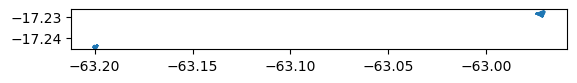

In [115]:
gdf_lines.plot()

In [116]:
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

In [117]:
output_path = 'output_lines_with_names_shapefile.shp'
gdf_lines_utm.to_file(output_path)